In [9]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"miske01","key":"1fb5c9c5be6ead6c58e09d0a5e1526f1"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection
!mkdir Dataset
!unzip -I 'utf-8' 'state-farm-distracted-driver-detection.zip' -d 'Dataset'

In [11]:
from fastai import *
from fastai.vision import *
from pathlib import Path
import numpy as np
import pandas as pd

In [12]:
train = Path('Dataset/imgs/train')
test = Path('Dataset/imgs/test')

data_train = (ImageList.from_folder(train)
             .split_by_rand_pct(0.2)
             .label_from_folder()
             .transform(get_transforms(do_flip=False),size = 224)
             ).databunch(bs = 32).normalize(imagenet_stats)

data_test = (ImageList.from_folder(test)
            .split_none()
            .label_from_folder()
            .transform(get_transforms(do_flip = False),size=224)
            )
data_test.valid = data_test.train
data_test = data_test.databunch(bs = 32).normalize(imagenet_stats)

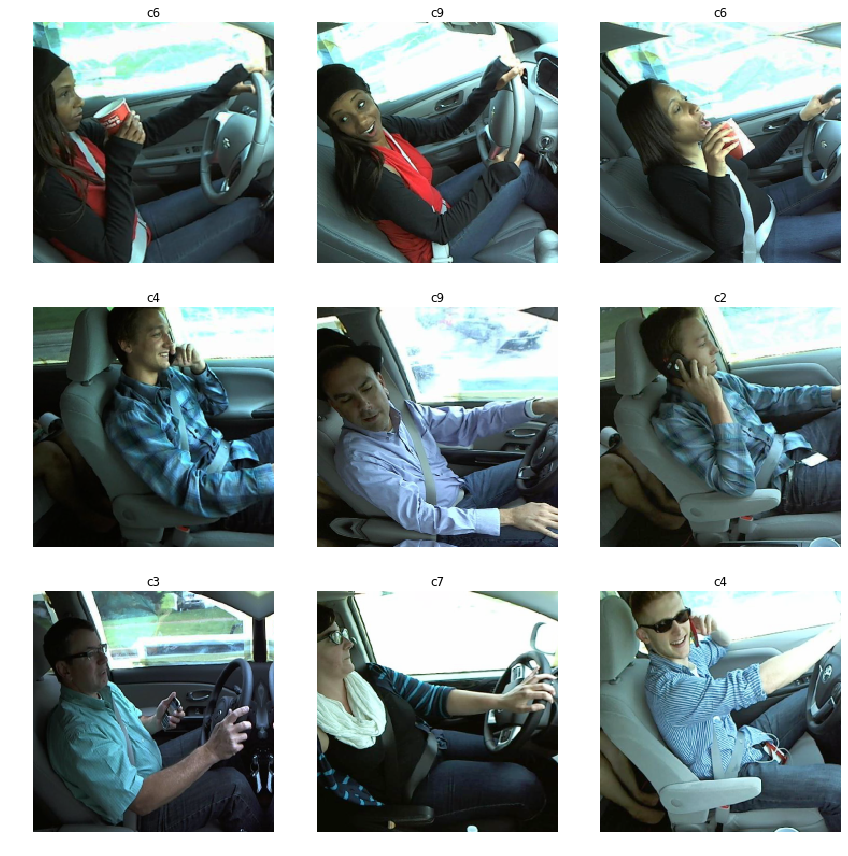

In [24]:
data_train.show_batch(3)

In [13]:
learner = cnn_learner(data_train,models.resnet34,metrics = accuracy)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [14]:
learner.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.633396,0.247482,0.924398,02:21
1,0.298547,0.096231,0.973461,02:19
2,0.212538,0.074244,0.980152,02:19


In [15]:
learner.save('stage-1')

In [16]:
learner.unfreeze()

In [18]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


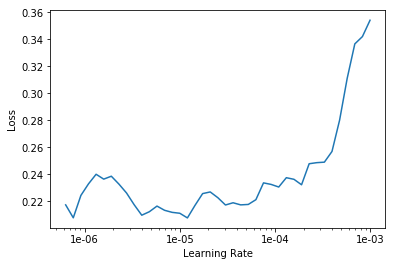

In [19]:
learner.recorder.plot()

In [20]:
learner.fit_one_cycle(3,slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.097889,0.050665,0.987511,03:17
1,0.047408,0.025030,0.995094,03:17
2,0.022874,0.017866,0.995986,03:17


In [22]:
learner.data.valid_dl = data_test.valid_dl
preds = learner.get_preds(DatasetType.Valid)

names = [path for path in test.ls()]
labels = pd.DataFrame(names,columns = ['img'])
labels.img = labels.img.astype(str)
labels = labels.img.str.rsplit('/',1,expand=True)
labels.drop(0,axis = 1 ,inplace = True)
labels.rename(columns={1:'img'},inplace = True)
columns = data_train.classes
submission = pd.DataFrame(preds[0].numpy(),columns = columns,index = [labels.img])
submission.reset_index(inplace = True)
submission.to_csv('submission.csv')